# 0.Librerías

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler 
import hdbscan
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

# 1. Clustering por producto

In [271]:
df = pd.read_csv(r"C:\Users\alici\Documents\master_data_science\proyecto_nuclio\TFM\datos_arreglados.csv", index_col=0)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

df.head()

,item,category,department,stores,region,week,year,is_holidays,units_sold,sell_price,total_sales
date,,,,,,,,,,,
2013-07-08,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,0,0,12.7414,0.0000
2013-07-15,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,28,2013,1,0,12.7414,0.0000
2013-07-22,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,29,2013,0,4,10.9858,43.9432
2013-07-29,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,30,2013,0,6,10.9858,65.9148
2013-08-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End(BOS_1),Boston,31,2013,0,0,10.9858,0.0000


Con las variables que tenemos vamos a obtener el porcentaje de ventas por *quarter* y *region* de cada producto, el precio medio total por producto y la cantidad de unidades vendidas de cada uno.

In [272]:
# Creamos una columna 'quarter' a partir del índice 'date'
df['quarter'] = df.index.month // 4 + 1

# Calculamos los porcentajes de ventas por ítem y cuatrimestre
df_perc_quarter_item = pd.crosstab(df['item'], df['quarter'], values=df['total_sales'], aggfunc='sum', normalize='index')

# Calculamos las unidades totales vendidas por ítem
units_total_by_item = df.groupby('item')['units_sold'].sum()

# Calculamos el precio medio por ítem
average_price_by_item = df.groupby('item').apply(lambda x: (x['total_sales'].sum() / x['units_sold'].sum()))

# Convertimos las Series en DataFrames para unirlos más fácilmente después
units_total_by_item_df = units_total_by_item.reset_index(name='units_total')
average_price_by_item_df = average_price_by_item.reset_index(name='avg_price')

# Unimos los DataFrames para tener todos los datos juntos
df_final = df_perc_quarter_item.reset_index()  
df_final = df_final.merge(units_total_by_item_df, on='item')
df_final = df_final.merge(average_price_by_item_df, on='item')

df_final.head()

,item,1,2,3,4,units_total,avg_price
0,ACCESORIES_1_001,0.281263,0.269487,0.351586,0.097664,4051,11.000712
1,ACCESORIES_1_002,0.199654,0.276641,0.344166,0.179539,5047,5.279317
2,ACCESORIES_1_003,0.289062,0.323099,0.258637,0.129202,1405,3.938599
3,ACCESORIES_1_004,0.266751,0.332820,0.313277,0.087152,38996,6.006287
4,ACCESORIES_1_005,0.234197,0.285362,0.376911,0.103530,14529,3.807422


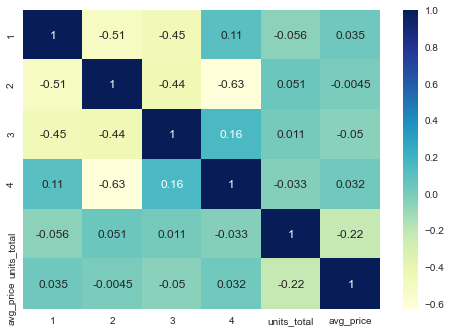

In [273]:
# Obtenemos la correlación de las diferentes variables
sns.heatmap(df_final.corr(), annot=True, cmap="YlGnBu");

Ya que ninguna tiene una alta correlación, no vamos a proceder a eliminar variables.

In [274]:
df_cluster_product= df_final.copy()

In [275]:
# Guardamos la variable 'ítem'
productos = df_cluster_product.pop('item')
productos

0        ACCESORIES_1_001
1        ACCESORIES_1_002
2        ACCESORIES_1_003
3        ACCESORIES_1_004
4        ACCESORIES_1_005
              ...        
3044    SUPERMARKET_3_823
3045    SUPERMARKET_3_824
3046    SUPERMARKET_3_825
3047    SUPERMARKET_3_826
3048    SUPERMARKET_3_827
Name: item, Length: 3049, dtype: object

In [276]:
# Cambiamos todos los nombres de las columnas a strings
df_cluster_product.columns = df_cluster_product.columns.astype(str)
# Estandarizamos las características
ss = StandardScaler()
df_cluster_product_ss = pd.DataFrame(
    ss.fit_transform(df_cluster_product),
    columns= df_cluster_product.columns)
df_cluster_product_ss

,1,2,3,4,units_total,avg_price
0,0.294480,-0.998906,0.649205,0.670123,-0.394344,1.203613
1,-1.474984,-0.875332,0.475104,3.978920,-0.371743,-0.060003
2,0.463571,-0.072881,-1.531710,1.944648,-0.454387,-0.356112
3,-0.020167,0.095021,-0.249666,0.245283,0.398622,0.100554
4,-0.726012,-0.724695,1.243415,0.907168,-0.156579,-0.385083
...,...,...,...,...,...,...
3044,0.402209,-1.089143,0.807590,0.407662,-0.139311,-0.495808
3045,-1.021481,1.647326,-0.463141,-1.152677,-0.297586,-0.551936
3046,0.737654,0.149883,-0.784165,-0.374962,-0.180723,-0.151334
3047,-0.540336,0.997243,-0.526538,-0.419265,-0.211221,-0.886764


Probamos con HDBSCAN...

In [277]:
# Inicializamos el algoritmo HDBSCAN 
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=5)

# Ajustamos el modelo y predecimos las etiquetas de clúster
cluster_labels = clusterer.fit_predict(df_cluster_product_ss)

# Agregamos las etiquetas del clúster al DataFrame original
df_final['cluster_hdbscan'] = cluster_labels

df_final

,item,1,2,3,4,units_total,avg_price,cluster_hdbscan
0,ACCESORIES_1_001,0.281263,0.269487,0.351586,0.097664,4051,11.000712,1
1,ACCESORIES_1_002,0.199654,0.276641,0.344166,0.179539,5047,5.279317,1
2,ACCESORIES_1_003,0.289062,0.323099,0.258637,0.129202,1405,3.938599,1
3,ACCESORIES_1_004,0.266751,0.332820,0.313277,0.087152,38996,6.006287,1
4,ACCESORIES_1_005,0.234197,0.285362,0.376911,0.103530,14529,3.807422,1
...,...,...,...,...,...,...,...,...
3044,SUPERMARKET_3_823,0.286232,0.264262,0.358336,0.091170,15290,3.306083,1
3045,SUPERMARKET_3_824,0.220570,0.422692,0.304179,0.052560,8315,3.051947,1
3046,SUPERMARKET_3_825,0.301703,0.335997,0.290497,0.071804,13465,4.865789,1
3047,SUPERMARKET_3_826,0.242761,0.385055,0.301477,0.070708,12121,1.535917,1


In [279]:
df_final.cluster_hdbscan.value_counts()

 1    2899
-1     143
 0       7
Name: cluster_hdbscan, dtype: int64

Hacemos unas segunda iteración con KMeans...

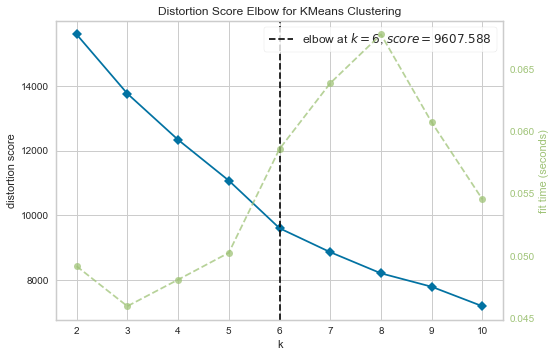

In [280]:
Elbow_M = KElbowVisualizer(KMeans(random_state=42, init="random", n_init="auto"), k=10)
Elbow_M.fit(df_cluster_product_ss)
Elbow_M.show();

In [281]:
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")
    kmeans.fit(df_cluster_product_ss)
    silhouette_scores.append(silhouette_score(df_cluster_product_ss, kmeans.labels_))

fig = px.line(
    x=range(2, 10),
    y=silhouette_scores,
    title="Silhouette score",
    labels={"x": "k", "y": "Silhouette score"},
)
fig.show()

In [282]:
kmeans= KMeans(n_clusters=6,random_state=42, init="random", n_init="auto")
kmeans.fit(df_cluster_product_ss)
df_final["cluster_kmeans"] = kmeans.labels_

c:\Users\alici\anaconda3\envs\Nuclio_env\lib\site-packages\sklearn\base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



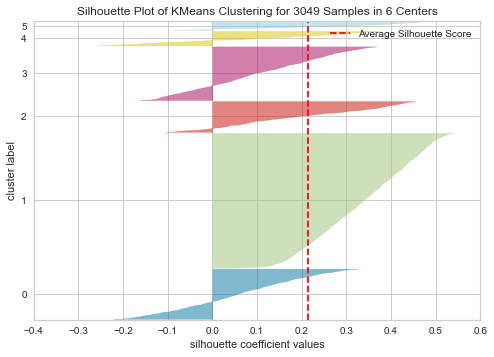

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3049 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [283]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df_cluster_product_ss)  
visualizer.show()

In [284]:
df_final.head()

,item,1,2,3,4,units_total,avg_price,cluster_hdbscan,cluster_kmeans
0,ACCESORIES_1_001,0.281263,0.269487,0.351586,0.097664,4051,11.000712,1,2
1,ACCESORIES_1_002,0.199654,0.276641,0.344166,0.179539,5047,5.279317,1,0
2,ACCESORIES_1_003,0.289062,0.323099,0.258637,0.129202,1405,3.938599,1,3
3,ACCESORIES_1_004,0.266751,0.332820,0.313277,0.087152,38996,6.006287,1,1
4,ACCESORIES_1_005,0.234197,0.285362,0.376911,0.103530,14529,3.807422,1,0


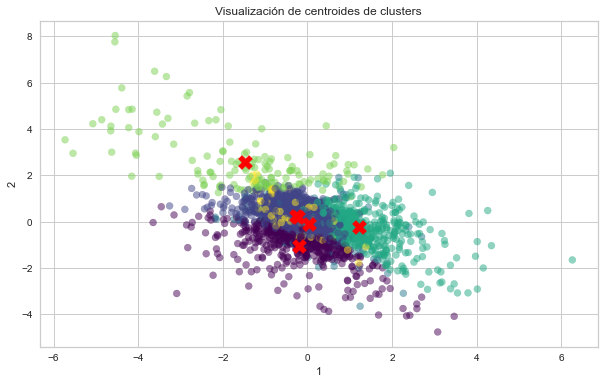

In [285]:
# Obtenemos las coordenadas de los centroides y las etiquetas de cluster
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Ahora, graficamos los puntos de datos y los centroides
plt.figure(figsize=(10, 6))

# Graficamos los puntos de datos
# Suponiendo que las columnas que deseas graficar son las dos primeras del DataFrame
plt.scatter(df_cluster_product_ss.iloc[:, 0], df_cluster_product_ss.iloc[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)

# Graficamos los centroides
# Asumiendo que las dos primeras columnas corresponden con las posiciones de los centroides
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200)

plt.title('Visualización de centroides de clusters')
plt.xlabel(df_cluster_product_ss.columns[0]) 
plt.ylabel(df_cluster_product_ss.columns[1])  

# Mostramos el gráfico
plt.show()


Probamos ahora con Gaussian Mixture...

In [289]:
# Rango de valores de 'n_components' a probar
n_components_range = range(1, 11)
bic_scores = []

# Calculamos el BIC para cada 'n_components'
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(df_cluster_product_ss)
    bic_scores.append(gmm.bic(df_cluster_product_ss))

# Encontramos el 'n_components' con el BIC más bajo
optimal_n_components = n_components_range[np.argmin(bic_scores)]

# Imprimimos el número óptimo de componentes
print(f'Número óptimo de componentes según el BIC: {optimal_n_components}')

# Inicializamos y ajustamos el GMM con el número óptimo de componentes
gmm_optimal = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm_optimal.fit(df_cluster_product_ss)
cluster_labels = gmm_optimal.predict(df_cluster_product_ss)

# Agregamos las etiquetas del clúster al DataFrame original
df_final['cluster_gaussian'] = cluster_labels

df_final

Número óptimo de componentes según el BIC: 9


,item,1,2,3,4,units_total,avg_price,cluster_hdbscan,cluster_kmeans,cluster_gaussian
0,ACCESORIES_1_001,0.281263,0.269487,0.351586,0.097664,4051,11.000712,1,2,6
1,ACCESORIES_1_002,0.199654,0.276641,0.344166,0.179539,5047,5.279317,1,0,8
2,ACCESORIES_1_003,0.289062,0.323099,0.258637,0.129202,1405,3.938599,1,3,4
3,ACCESORIES_1_004,0.266751,0.332820,0.313277,0.087152,38996,6.006287,1,1,1
4,ACCESORIES_1_005,0.234197,0.285362,0.376911,0.103530,14529,3.807422,1,0,7
...,...,...,...,...,...,...,...,...,...,...
3044,SUPERMARKET_3_823,0.286232,0.264262,0.358336,0.091170,15290,3.306083,1,0,7
3045,SUPERMARKET_3_824,0.220570,0.422692,0.304179,0.052560,8315,3.051947,1,4,7
3046,SUPERMARKET_3_825,0.301703,0.335997,0.290497,0.071804,13465,4.865789,1,3,1
3047,SUPERMARKET_3_826,0.242761,0.385055,0.301477,0.070708,12121,1.535917,1,1,7


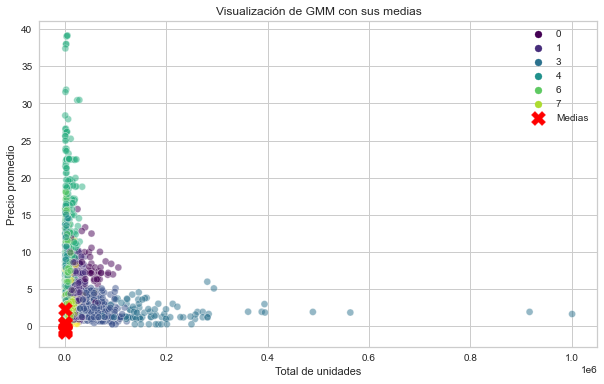

In [290]:
# Medias de los componentes gaussianos
means = gmm_optimal.means_

# Creamos el gráfico de dispersión con seaborn
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='units_total', y='avg_price', hue="cluster_gaussian", palette='viridis', data=df_final, alpha=0.5)

# Graficamos las medias de los componentes gaussianos
# Aquí necesitamos obtener los índices de 'units_total' y 'avg_price' en 'df_cluster_product_ss'
idx_units_total = df_cluster_product_ss.columns.get_loc('units_total')
idx_avg_price = df_cluster_product_ss.columns.get_loc('avg_price')
plt.scatter(means[:, idx_units_total], means[:, idx_avg_price], c='red', marker='X', s=200, label='Medias')

plt.title('Visualización de GMM con sus medias')
plt.xlabel('Total de unidades')
plt.ylabel('Precio promedio')
plt.legend()

plt.show()